<a href="https://colab.research.google.com/github/jammi-kunal/ML-assignments/blob/main/21233_final_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import string
from sklearn.preprocessing import LabelEncoder as le, OrdinalEncoder as oe, StandardScaler as ss, MinMaxScaler as mms, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import plot_tree

In [2]:
path = f'/content/drive/MyDrive/Colab Notebooks/hackathons/AnalyticsOlympiad2022Data/data/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv(path+'train.csv')

In [5]:
train.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   105000 non-null  int64  
 1   AGE                  105000 non-null  object 
 2   GENDER               105000 non-null  object 
 3   DRIVING_EXPERIENCE   105000 non-null  object 
 4   EDUCATION            105000 non-null  object 
 5   INCOME               105000 non-null  object 
 6   CREDIT_SCORE         105000 non-null  float64
 7   VEHICLE_OWNERSHIP    105000 non-null  float64
 8   VEHICLE_YEAR         105000 non-null  object 
 9   MARRIED              105000 non-null  float64
 10  CHILDREN             105000 non-null  float64
 11  POSTAL_CODE          105000 non-null  int64  
 12  ANNUAL_MILEAGE       105000 non-null  float64
 13  SPEEDING_VIOLATIONS  105000 non-null  int64  
 14  DUIS                 105000 non-null  int64  
 15  PAST_ACCIDENTS   

In [7]:
train['ID'].duplicated().sum()

6515

In [8]:
train.columns = [x.lower() for x in list(train.columns)]

In [9]:
train['outcome'].value_counts()

0.0    60622
1.0    44378
Name: outcome, dtype: int64

In [10]:
train.isnull().sum()

id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
type_of_vehicle        0
dtype: int64

In [11]:
train.duplicated().sum()

0

#### Numerical columns:
- id
- credit_score
- vehicle_ownership
- married
- children
- postal_code
- annual_mileage
- speeding_violations
- duis
- past_accidents
- outcome

#### Categorical columns:
- age
- gender
- driving_experience
- education
- income
- vehicle_year
- type_of_vehicle

### No duplicates and Null values

In [12]:
def check_value_cnts(var):
    print('------------------------------------------------------------------------')
    print(train[var].value_counts())

In [13]:
nums = list(train.select_dtypes(include='number').columns)
cats = list(train.select_dtypes(include='object').columns)

In [14]:
list(map(check_value_cnts, cats))

------------------------------------------------------------------------
40-64    33716
65+      32962
26-39    20018
16-25    18304
Name: age, dtype: int64
------------------------------------------------------------------------
male      65317
female    39683
Name: gender, dtype: int64
------------------------------------------------------------------------
20-29y    37493
0-9y      33111
10-19y    25101
30y+       9295
Name: driving_experience, dtype: int64
------------------------------------------------------------------------
high school    46590
university     31220
none           27190
Name: education, dtype: int64
------------------------------------------------------------------------
upper class      51271
working class    24454
middle class     14738
poverty          14537
Name: income, dtype: int64
------------------------------------------------------------------------
before 2015    57511
after 2015     47489
Name: vehicle_year, dtype: int64
-----------------------------

[None, None, None, None, None, None, None]

### Feature transformation and encoding

#### Features to be Label Encoded(Nominal):
- gender
- type_of_vehicle
- vehicle_year

#### Features to be Ordinal Encoded(Ordinal):
- age
- driving_experience
- education
- income

In [15]:
y = train['outcome']
X = train.drop('outcome', axis = 1)

In [16]:
X.drop(['id', 'postal_code'], axis = 1, inplace = True)

In [17]:
nums = X.select_dtypes(include='number').columns
ohei = ['gender','type_of_vehicle', 'vehicle_year']
ordi = ['age','driving_experience','education','income']

In [18]:
agec = ['16-25','26-39','40-64','65+']
dexp = ['0-9y','10-19y','20-29y','30y+']
educ = ['none','high school','university']
inco = ['poverty','working class','middle class','upper class']

In [19]:
cat_pipeline = Pipeline(
    steps=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ]
)

ord_pipeline = Pipeline(
    steps=[
        ("ord", oe(categories = [agec, dexp, educ, inco])),
        ("scaler", ss())
    ]
)

num_pipeline = Pipeline(
    steps=[
        ("scaler", ss())
    ]
)

In [20]:
transform = ColumnTransformer(
    transformers=[
        ("nums", num_pipeline, nums),
        ("cats", cat_pipeline, ohei),
        ("ords", ord_pipeline, ordi)
    ]
)

In [21]:
X1 = transform.fit_transform(X)

In [22]:
transform.transformers_

[('nums',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['credit_score', 'vehicle_ownership', 'married', 'children',
         'annual_mileage', 'speeding_violations', 'duis', 'past_accidents'],
        dtype='object')),
 ('cats',
  Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))]),
  ['gender', 'type_of_vehicle', 'vehicle_year']),
 ('ords', Pipeline(steps=[('ord',
                   OrdinalEncoder(categories=[['16-25', '26-39', '40-64', '65+'],
                                              ['0-9y', '10-19y', '20-29y',
                                               '30y+'],
                                              ['none', 'high school',
                                               'university'],
                                              ['poverty', 'working class',
                                               'middle class', 'upper class']])),
                  ('scaler', StandardScaler())]), ['age',
   'driving_experience',
   'ed

In [23]:
X.duplicated().sum()

0

In [24]:
y.value_counts()/len(y)

0.0    0.577352
1.0    0.422648
Name: outcome, dtype: float64

***

In [25]:
col_names = list(nums)+['female',
                        'male',
                        'vehicle_hatchback',
                        'vehicle_suv',
                        'vehicle_sedan',
                        'vehicle_sports_car',
                        'vehicle_year_after_2015',
                        'vehicle_year_before_2015']+ordi

In [26]:
X1 = pd.DataFrame(X1, columns = col_names)

## Data Visualization

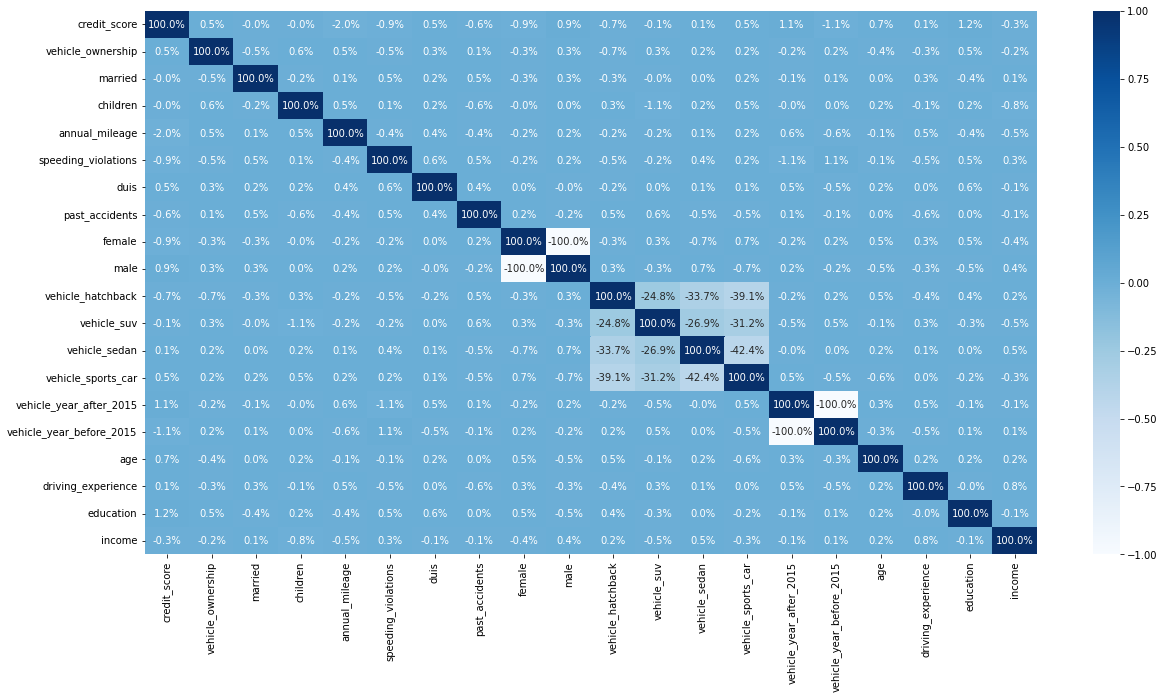

In [163]:
# heatmap
plt.figure(figsize = (20,10))
sns.heatmap(X1.corr(), cmap = 'Blues', annot = True, fmt = '.1%')
plt.show()

### Inference
- No correlation among the features

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


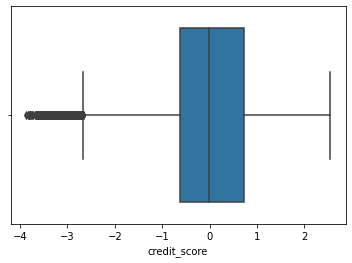

In [145]:
sns.boxplot(X1["credit_score"])
plt.show()

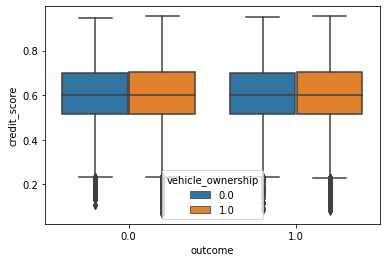

In [148]:
sns.boxplot(x ='outcome', y ='credit_score', data = train, hue ='vehicle_ownership')

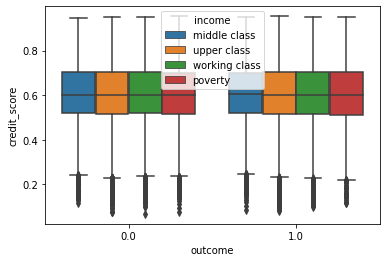

In [149]:
sns.boxplot(x ='outcome', y ='credit_score', data = train, hue ='income')

## Feature Selection

In [28]:
X1.shape

(105000, 20)

In [ ]:
# 20 dimensional data

In [29]:
pca = PCA(.8)

In [30]:
fit_pca = pca.fit(X1)

In [31]:
fit_pca.explained_variance_ratio_

array([0.07503854, 0.07452225, 0.0741998 , 0.07362236, 0.07321692,
       0.07305323, 0.07278996, 0.07247858, 0.07234279, 0.072123  ,
       0.07169455])

In [ ]:
# 11 dimensional data

In [32]:
X2 = pca.transform(X1)

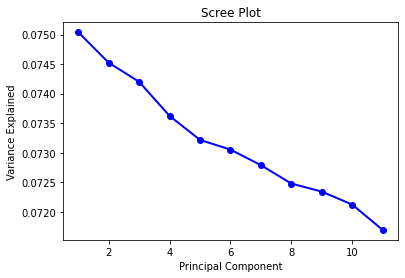

In [33]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Train Test Splitting

In [34]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X2,y,test_size = .1, stratify = y)

In [35]:
print(Xtrain.shape)
print(Xtest.shape)

(94500, 11)
(10500, 11)


## Modeling

In [114]:
def print_acc(model,Xtrain,Xtest,ytrain,ytest):
    print('------------------------------------------|')
    print(f'|  Training Accuracy | {log_loss(ytrain, model.predict(Xtrain))} |')
    print('------------------------------------------|')
    print(f'|  Test Accuracy     | {log_loss(ytest, model.predict(Xtest))} |')
    print('------------------------------------------|')

def gen_conf(actual,pred):
    classes = [0,1]
    cm = confusion_matrix(actual,pred, labels=classes)
    sn.heatmap(cm/np.sum(cm),fmt = '.2%', annot=True)
    plt.title("Confusion matrix")
    plt.show()

### Naive Bayes

In [122]:
gnb = BernoulliNB()
gnb.fit(Xtrain, ytrain)
pred = gnb.predict(Xtest)
print(log_loss(ytest, gnb.predict_proba(Xtest)))

0.6811392280324836


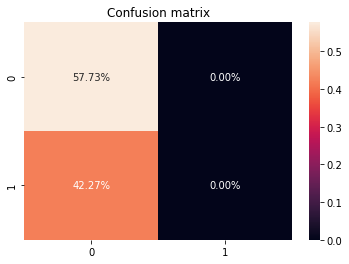

In [123]:
gen_conf(ytest, pred)

### From the basic Naive Bayes model we can see that the false negatives are high. The True negatives are very low and the False Positives are very low. 
### We must decrease the False Negatives.
***

### Random Forest Classifier

In [127]:
dtc = RandomForestClassifier(n_jobs = -1)
dtc.fit(Xtrain, ytrain)
dpred = dtc.predict(Xtest)
log_loss(ytest, dpred)

15.999802487753382

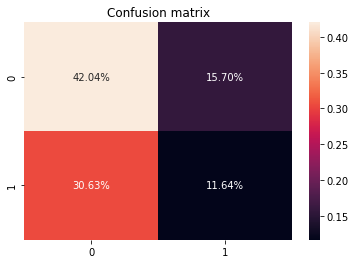

In [128]:
gen_conf(ytest, dpred)

***

### XGBoost with RandomizedSearchCV

In [36]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.02, 0.05]    
        }

In [67]:
skf = StratifiedKFold(n_splits = 10, shuffle = True)

In [68]:
xgc = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective = 'binary:logistic', nthread = 6, tree_method = 'gpu_hist', eval_metric = 'logloss')

In [69]:
random_cv = RandomizedSearchCV(xgc,param_distributions = params, n_jobs = -1, cv = skf.split(Xtrain,ytrain), n_iter = 50, scoring = 'neg_log_loss')

In [70]:
random_cv.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fcdb416bed0>,
                   estimator=XGBClassifier(eval_metric='logloss',
                                           learning_rate=0.01, nthread=6,
                                           tree_method='gpu_hist'),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 0.5, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='neg_log_loss')

In [71]:
random_cv.best_params_

{'kernel': 'linear', 'gamma': 0.0001, 'C': 0.1}

In [72]:
random_cv.best_score_

-0.6828250229308213

In [73]:
#random_cv.fit(Xtrain, ytrain)
pred_proba = random_cv.predict_proba(Xtrain)
preds = random_cv.predict(Xtrain)
print(log_loss(ytrain, pred_proba))

0.6822770970826426


In [74]:
test_preds = random_cv.predict_proba(Xtest)
print(log_loss(ytest, test_preds))

0.6827907506624857


In [75]:
test_pred = random_cv.predict(Xtest)

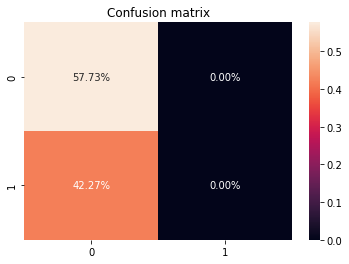

In [126]:
gen_conf(ytest, test_pred)

In [93]:
# this function adjusts the probability
def change_probas(pred_probas, p):
    x = []
    for i in pred_probas:
        if i[1] > p:
            x.append(i[1])
        else:
            x.append(i[0])
    return np.array(x)

def return_probas(pred_probas, p):
    x = []
    for i in pred_probas:
        if i[1] > p:
            x.append(1.0)
        else:
            x.append(0.0)
    return np.array(x)

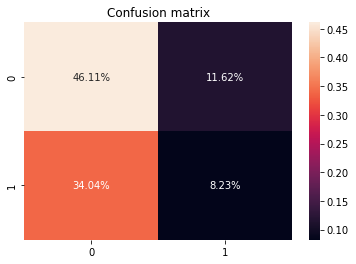

In [141]:
gen_conf(ytest, return_probas(test_preds, .454))

***